In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import kagglehub
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
base_path = kagglehub.dataset_download('nltkdata/movie-review')

# Find the CSV file in the directory
csv_files = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

if csv_files:
    # Use the first CSV file found
    data = pd.read_csv(csv_files[0], delimiter=',', nrows=None)
    print("Data loaded successfully:")
    print(data)
else:
    print(f"No CSV files found in {base_path}")
    print("Available files:", os.listdir(base_path))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data loaded successfully:
       fold_id cv_tag  html_id  sent_id  \
0            0  cv000    29590        0   
1            0  cv000    29590        1   
2            0  cv000    29590        2   
3            0  cv000    29590        3   
4            0  cv000    29590        4   
...        ...    ...      ...      ...   
64715        9  cv999    14636       20   
64716        9  cv999    14636       21   
64717        9  cv999    14636       22   
64718        9  cv999    14636       23   
64719        9  cv999    14636       24   

                                                    text  tag  
0      films adapted from comic books have had plenty...  pos  
1      for starters , it was created by alan moore ( ...  pos  
2      to say moore and campbell thoroughly researche...  pos  
3      the book ( or " graphic novel , " if you will ...  pos  
4      in other words , don't dismiss this film becau...  pos  
...                                                  ...  ...  
64715  th

In [48]:
#check if there are any nulls
print('data nulls: \n', data.isnull().sum())

#check if there are any duplicates
print('\n data duplicates:', data.duplicated().sum())

#check data types
print('\ndata types:\n', data.dtypes)

#check value counts for categorical columns
print('\ntag value counts:\n', data['tag'].value_counts())
print('\ncv_tag value counts (first 10):\n', data['cv_tag'].value_counts().head(10))

#check basic statistics for any numeric columns
print('\nbasic statistics:\n', data.describe())

#check for any unusual characters or patterns in text
print('\nsample of text data:\n', data['text'].head())

#check distribution of text lengths
data['text_length'] = data['text'].str.len()
print('\ntext length statistics:\n', data['text_length'].describe())
print('\ntext length distribution:\n', pd.qcut(data['text_length'], q=4).value_counts())


data nulls: 
 fold_id    0
cv_tag     0
html_id    0
sent_id    0
text       0
tag        0
dtype: int64

 data duplicates: 0

data types:
 fold_id     int64
cv_tag     object
html_id     int64
sent_id     int64
text       object
tag        object
dtype: object

tag value counts:
 tag
pos    32937
neg    31783
Name: count, dtype: int64

cv_tag value counts (first 10):
 cv_tag
cv256    166
cv501    153
cv122    145
cv638    144
cv623    143
cv893    141
cv765    141
cv100    139
cv992    137
cv732    137
Name: count, dtype: int64

basic statistics:
             fold_id       html_id      sent_id
count  64720.000000  64720.000000  64720.00000
mean       4.549382  16074.097373     18.98118
std        2.853176   7175.282521     15.08369
min        0.000000     42.000000      0.00000
25%        2.000000  10613.000000      8.00000
50%        5.000000  15091.000000     16.00000
75%        7.000000  21865.000000     27.00000
max        9.000000  29867.000000    111.00000

sample of text data:


In [49]:

# Group by review (using html_id) before any randomization
def prepare_data(df, shuffle=True):
    # Generate different random numbers for positive and negative reviews
    np.random.seed(42)  # for reproducibility
    val_cv_numbers_pos = np.random.choice(1000, size=100, replace=False)
    
    np.random.seed(43)  # different seed for negative reviews
    val_cv_numbers_neg = np.random.choice(1000, size=100, replace=False)
    
    # Convert to cv format (cv000, cv001, etc.)
    val_cv_tags_pos = [f'cv{str(num).zfill(3)}' for num in val_cv_numbers_pos]
    val_cv_tags_neg = [f'cv{str(num).zfill(3)}' for num in val_cv_numbers_neg]
    
    # Split positive reviews
    val_pos = df[(df['cv_tag'].isin(val_cv_tags_pos)) & (df['tag'] == 'pos')]
    train_pos = df[(~df['cv_tag'].isin(val_cv_tags_pos)) & (df['tag'] == 'pos')]
    
    # Split negative reviews
    val_neg = df[(df['cv_tag'].isin(val_cv_tags_neg)) & (df['tag'] == 'neg')]
    train_neg = df[(~df['cv_tag'].isin(val_cv_tags_neg)) & (df['tag'] == 'neg')]
    
    # Combine the splits
    val_df = pd.concat([val_pos, val_neg])
    train_df = pd.concat([train_pos, train_neg])
    
   # Validation checks
    print("=== VALIDATION CHECKS ===")
    
    # 1. Check unique cv_tags in validation set
    val_pos_cvs = val_pos['cv_tag'].unique()
    val_neg_cvs = val_neg['cv_tag'].unique()
    print(f"\n1. Number of unique cv_tags in validation:")
    print(f"Positive: {len(val_pos_cvs)} (should be 100)")
    print(f"Negative: {len(val_neg_cvs)} (should be 100)")
    
    # 2. Check for overlap between positive and negative html_ids
    val_pos_html_ids = val_pos['html_id'].unique()
    val_neg_html_ids = val_neg['html_id'].unique()
    overlap = set(val_pos_html_ids) & set(val_neg_html_ids)
    print(f"\n2. Overlap between pos/neg html_ids: {len(overlap)} (should be 0)")
    
    # 3. Check that all sentences from same review stay together
    val_html_ids = val_df['html_id'].unique()
    split_reviews = df[df['html_id'].isin(val_html_ids)].shape[0] - val_df.shape[0]
    print(f"\n3. Number of split reviews: {split_reviews} (should be 0)")
    
    # 4. Check distributions
    print("\n4. Data distribution:")
    print("\nTraining set:")
    print(train_df.groupby('tag')['cv_tag'].nunique())
    print("\nValidation set:")
    print(val_df.groupby('tag')['cv_tag'].nunique())
    
    # 5. Check for any cv_tags in both train and validation
    train_html_ids = set(train_df['html_id'].unique())
    val_html_ids = set(val_df['html_id'].unique())
    overlap_train_val = train_html_ids & val_html_ids
    print(f"\n5. Overlap between train/val html_ids: {len(overlap_train_val)} (should be 0)")
    
    if shuffle:
        # Shuffle at the review level
        def shuffle_reviews(df):
            review_ids = df['html_id'].unique()
            np.random.shuffle(review_ids)
            return pd.concat([
                df[df['html_id'] == rid].sort_values('sent_id') 
                for rid in review_ids
            ]).reset_index(drop=True)
        
        train_df = shuffle_reviews(train_df)
        val_df = shuffle_reviews(val_df)

    #convert 'tag' to numerical format
    train_df['tag'] = train_df['tag'].map({'pos': 1, 'neg': 0})
    val_df['tag'] = val_df['tag'].map({'pos': 1, 'neg': 0})

    return train_df, val_df

# Run the function
train_data, val_data = prepare_data(data, shuffle=True)


=== VALIDATION CHECKS ===

1. Number of unique cv_tags in validation:
Positive: 100 (should be 100)
Negative: 100 (should be 100)

2. Overlap between pos/neg html_ids: 0 (should be 0)

3. Number of split reviews: 0 (should be 0)

4. Data distribution:

Training set:
tag
neg    900
pos    900
Name: cv_tag, dtype: int64

Validation set:
tag
neg    100
pos    100
Name: cv_tag, dtype: int64

5. Overlap between train/val html_ids: 0 (should be 0)


In [50]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and extra whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Simple word tokenization (splitting on whitespace)
    # This is a simpler alternative to NLTK's word_tokenize
    tokens = text.split()
    
    # Remove stop words (optional)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

# Apply preprocessing to both sets
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
val_data['processed_text'] = val_data['text'].apply(preprocess_text)

# Check results
print("Original text:")
print(train_data['text'].iloc[0])
print("\nProcessed text:")
print(train_data['processed_text'].iloc[0])

# Get vocabulary statistics
all_words = ' '.join(train_data['processed_text']).split()
vocab_size = len(set(all_words))
print(f"\nVocabulary size: {vocab_size}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16073\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16073\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original text:
i've heard it called " jaws with claws " and that's a fair summation of the plot , though that tag line does little to quantify quality .

Processed text:
heard called jaws claws fair summation plot though tag line little quantify quality

Vocabulary size: 37867


In [51]:
from collections import Counter

def create_vocabulary(texts, min_freq=2):
    # Count word frequencies
    word_freq = Counter()
    for text in texts:
        word_freq.update(text.split())
    
    # Create vocabulary with special tokens
    vocab = {
        '<PAD>': 0,
        '<UNK>': 1,
    }
    
    # Add words that appear at least min_freq times
    idx = len(vocab)
    for word, count in word_freq.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab, word_freq

def convert_to_sequences(texts, vocab, max_length=25):
    sequences = []
    for text in texts:
        # Convert words to indices
        sequence = [vocab.get(word, vocab['<UNK>']) for word in text.split()]
        
        # Truncate or pad sequence
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence += [vocab['<PAD>']] * (max_length - len(sequence))
        
        sequences.append(sequence)
    
    return np.array(sequences)

# Create vocabulary from training data only
vocab, word_freq = create_vocabulary(train_data['processed_text'])
print(f"Vocabulary size: {len(vocab)}")
print(f"Most common words: {sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]}")

# Convert text to sequences
X_train = convert_to_sequences(train_data['processed_text'], vocab)
X_val = convert_to_sequences(val_data['processed_text'], vocab)

# Convert labels to numerical format
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['tag'])
y_val = label_encoder.transform(val_data['tag'])

print(f"\nTraining shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

max_length = X_train.shape[1]



Vocabulary size: 24287
Most common words: [('film', 8501), ('one', 5242), ('movie', 5108), ('like', 3333), ('even', 2318), ('good', 2199), ('time', 2162), ('story', 1971), ('would', 1897), ('much', 1848)]

Training shape: (58407, 25)
Validation shape: (6313, 25)


In [52]:
import keras

rnn =  keras.Sequential(name="Simple_RNN")
rnn.add(keras.layers.Embedding(len(vocab)+1,
                        max_length,
                        input_length=max_length))

rnn.add(keras.layers.SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(keras.layers.SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(keras.layers.Dense(1, activation='sigmoid'))
 
# printing model summary
print(rnn.summary())

rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


rnn.summary()

rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])





C:\Users\16073\MLPractice\venvs\venv3.12\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_15 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_15 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5084 - loss: 0.6927 - val_accuracy: 0.4925 - val_loss: 0.6932
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5781 - loss: 0.6664 - val_accuracy: 0.6333 - val_loss: 0.6513
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7331 - loss: 0.5341 - val_accuracy: 0.6399 - val_loss: 0.6515
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7918 - loss: 0.4433 - val_accuracy: 0.6468 - val_loss: 0.6809
Epoch 5/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8288 - loss: 0.3763 - val_accuracy: 0.6433 - val_loss: 0.8516


In [53]:
import numpy as np
import pandas as pd
import keras
from collections import Counter
import matplotlib.pyplot as plt
from keras import layers

def comprehensive_analysis():
    print("=== COMPREHENSIVE MODEL AND DATA ANALYSIS ===\n")
    
    # 1. Data Analysis
    print("1. DATA CHARACTERISTICS:")
    print(f"Training samples: {len(X_train)}")
    print(f"Vocabulary size: {len(vocab)}")
    print(f"Sequence length: {max_length}")
    
    # Class distribution
    print("\nClass distribution:")
    print(pd.Series(y_train).value_counts(normalize=True))
    
    # 2. Data Processing Check
    print("\n2. DATA PROCESSING ANALYSIS:")
    pad_ratio = np.mean(X_train == 0)
    print(f"Padding ratio: {pad_ratio:.2%}")
    
    # Token distribution
    token_counts = Counter(X_train.flatten())
    print("\nMost common tokens:")
    print(pd.DataFrame(token_counts.most_common(10), columns=['Token', 'Count']))
    
    # Sequence length analysis
    nonzero_lengths = [len(np.nonzero(seq)[0]) for seq in X_train]
    print(f"\nSequence length statistics:")
    print(f"Mean length (excluding padding): {np.mean(nonzero_lengths):.1f}")
    print(f"Median length (excluding padding): {np.median(nonzero_lengths):.1f}")
    
    

# Run the analysis
results = comprehensive_analysis()

=== COMPREHENSIVE MODEL AND DATA ANALYSIS ===

1. DATA CHARACTERISTICS:
Training samples: 58407
Vocabulary size: 24287
Sequence length: 25

Class distribution:
1    0.508877
0    0.491123
Name: proportion, dtype: float64

2. DATA PROCESSING ANALYSIS:
Padding ratio: 57.30%

Most common tokens:
   Token   Count
0      0  836638
1      1   13140
2    124    8371
3    411    5162
4     72    5040
5     69    3272
6     96    2285
7    294    2169
8    521    2116
9    129    1946

Sequence length statistics:
Mean length (excluding padding): 10.7
Median length (excluding padding): 10.0


=== PREPROCESSING OPTIMIZATION ===

Current sequence length: 25
Recommended sequence length: 23

Optimized Model Summary:


C:\Users\16073\MLPractice\venvs\venv3.12\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_5                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training optimized model:
Epoch 1/15
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.5351 - loss: 0.7431 - val_accuracy: 0.6404 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 2/15
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.7398 - loss: 0.5257 - val_accuracy: 0.6502 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 3/15
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.8028 - loss: 0.4233 - val_accuracy: 0.6377 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 4/15
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.8559 - loss: 0.3254 - val_accuracy: 0.6460 - val_loss: 0.9281 - learning_rate: 5.0000e-04
Epoch 5/15
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.8844 - loss: 0.2634 - val_accuracy: 0.6436 - val_loss: 0.9759 - learning_rate: 5.0000e-04


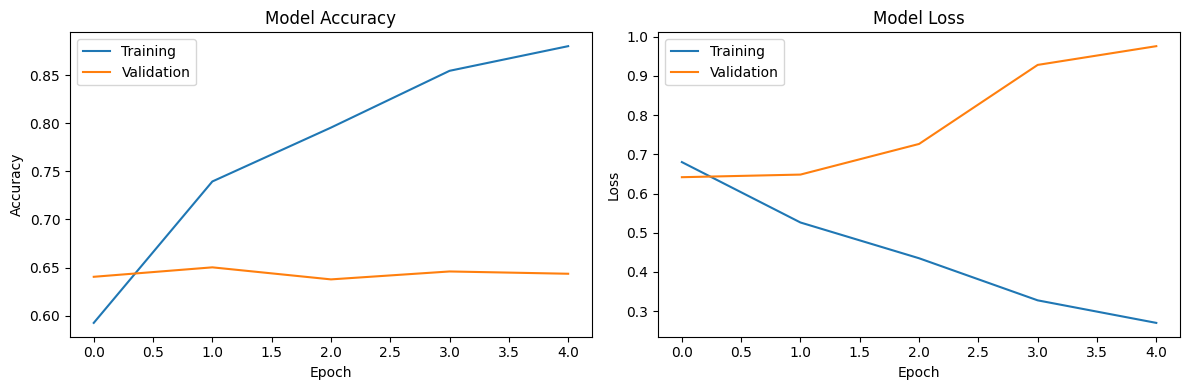


Final Best Validation Accuracy: 0.6502


In [54]:
def optimize_preprocessing():
    print("=== PREPROCESSING OPTIMIZATION ===\n")
    
    # 1. Find optimal sequence length
    nonzero_lengths = [len(np.nonzero(seq)[0]) for seq in X_train]
    optimal_length = int(np.percentile(nonzero_lengths, 95))  # Cover 95% of sequences
    print(f"Current sequence length: {max_length}")
    print(f"Recommended sequence length: {optimal_length}")
    
    # 2. Reprocess the data
    def reprocess_sequences(sequences, length):
        # Remove excessive padding and truncate/pad to optimal length
        new_sequences = []
        for seq in sequences:
            # Remove padding (zeros)
            nonzero_tokens = seq[seq != 0]
            # Take only the meaningful tokens up to optimal length
            processed = nonzero_tokens[:length]
            # Pad if necessary
            if len(processed) < length:
                processed = np.pad(processed, (0, length - len(processed)))
            new_sequences.append(processed)
        return np.array(new_sequences)
    
    # Reprocess train and validation sets
    X_train_processed = reprocess_sequences(X_train, optimal_length)
    X_val_processed = reprocess_sequences(X_val, optimal_length)
    
    # 3. Create optimized model for new sequence length
    model = keras.Sequential([
        # Embedding with proper size
        keras.layers.Embedding(len(vocab)+1, 100, input_length=optimal_length),
        keras.layers.SpatialDropout1D(0.2),
        
        # GRU instead of SimpleRNN (better for text)
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.GRU(64),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        # Dense layers
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile with proper learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print("\nOptimized Model Summary:")
    model.summary()
    
    # 4. Train with better callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.0001
        )
    ]
    
    print("\nTraining optimized model:")
    history = model.fit(
        X_train_processed, y_train,
        validation_data=(X_val_processed, y_val),
        epochs=15,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # 5. Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, history, X_train_processed, X_val_processed

# Run optimization
optimized_model, history, X_train_new, X_val_new = optimize_preprocessing()

# Print final metrics
final_val_acc = max(history.history['val_accuracy'])
print(f"\nFinal Best Validation Accuracy: {final_val_acc:.4f}")

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def convert_sequences_to_texts(sequences, vocab):
    # Create reverse mapping (index to word)
    idx_to_word = {idx: word for word, idx in vocab.items()}
    
    # Convert each sequence to text
    texts = []
    for seq in sequences:
        # Filter out padding (0s) and convert indices to words
        words = [idx_to_word.get(idx, '<UNK>') for idx in seq if idx != 0]
        texts.append(' '.join(words))
    
    return texts

# Convert sequences back to text
print("Converting sequences to text...")
X_train_texts = convert_sequences_to_texts(X_train, vocab)
X_val_texts = convert_sequences_to_texts(X_val, vocab)

# Create and fit TF-IDF vectorizer|
print("\nCreating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    min_df=5,          # Minimum document frequency
    max_df=0.7,        # Maximum document frequency
    ngram_range=(1,2)  # Use both unigrams and bigrams
)

X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_val_tfidf = tfidf.transform(X_val_texts)

print(f"\nTF-IDF features shape: {X_train_tfidf.shape}")

# Train logistic regression
print("\nTraining Logistic Regression...")
model = LogisticRegression(
    C=1.0,             # Regularization strength
    max_iter=200,      # Maximum iterations
    class_weight='balanced'  # Handle any class imbalance
)

model.fit(X_train_tfidf, y_train)

# Make predictions
train_preds = model.predict(X_train_tfidf)
val_preds = model.predict(X_val_tfidf)

# Print results
print("\nResults:")
print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))

print("\nDetailed Validation Report:")
print(classification_report(y_val, val_preds))

# Look at most important features
def print_important_features(model, vectorizer, n=20):
    # Get feature names and coefficients
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]
    
    # Sort features by importance
    important_features = sorted(zip(feature_names, coef), key=lambda x: abs(x[1]), reverse=True)
    
    print("\nMost Important Features:")
    print("Positive sentiment:")
    for word, score in important_features[:n]:
        if score > 0:
            print(f"{word}: {score:.4f}")
    
    print("\nNegative sentiment:")
    for word, score in important_features[:n]:
        if score < 0:
            print(f"{word}: {score:.4f}")

print_important_features(model, tfidf)

# Error analysis
def analyze_errors(texts, true_labels, predicted_labels, n=5):
    errors = [(text, true, pred) for text, true, pred 
              in zip(texts, true_labels, predicted_labels) 
              if true != pred]
    
    print("\nSample Misclassifications:")
    for text, true, pred in errors[:n]:
        print(f"\nText: {text[:200]}...")
        print(f"True label: {true}")
        print(f"Predicted: {pred}")

print("\nAnalyzing validation errors...")
analyze_errors(X_val_texts, y_val, val_preds)

Converting sequences to text...

Creating TF-IDF features...

TF-IDF features shape: (58407, 5000)

Training Logistic Regression...

Results:
Training Accuracy: 0.7230811375348846
Validation Accuracy: 0.6410581340091874

Detailed Validation Report:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      3098
           1       0.65      0.64      0.64      3215

    accuracy                           0.64      6313
   macro avg       0.64      0.64      0.64      6313
weighted avg       0.64      0.64      0.64      6313


Most Important Features:
Positive sentiment:
truman: 4.3600
mulan: 4.0712
flynt: 3.3316
bulworth: 2.9267
derek: 2.9199
lebowski: 2.8817
outstanding: 2.8376
bowfinger: 2.8275
cameron: 2.7566
jackie: 2.7314

Negative sentiment:
godzilla: -3.6842
seagal: -3.6510
worst: -3.6412
awful: -3.2515
nbsp: -3.1413
ridiculous: -2.9981
poorly: -2.9707
bats: -2.8378
harry: -2.7686
stupid: -2.7673

Analyzing validation errors...

Sampl


Model Summary:


C:\Users\16073\MLPractice\venvs\venv3.12\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training optimized model for small dataset...
Epoch 1/50
3651/3651 ━━━━━━━━━━━━━━━━━━━━ 73s 19ms/step - accuracy: 0.5653 - loss: 0.6892 - val_accuracy: 0.6380 - val_loss: 0.6395 - learning_rate: 5.0000e-04
Epoch 2/50
3651/3651 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - accuracy: 0.7111 - loss: 0.5767 - val_accuracy: 0.6556 - val_loss: 0.6470 - learning_rate: 5.0000e-04
Epoch 3/50
3649/3651 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7554 - loss: 0.5176
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
3651/3651 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - accuracy: 0.7554 - loss: 0.5176 - val_accuracy: 0.6441 - val_loss: 0.6860 - learning_rate: 5.0000e-04
Epoch 4/50
3651/3651 ━━━━━━━━━━━━━━━━━━━━ 69s 19ms/step - accuracy: 0.7859 - loss: 0.4667 - val_accuracy: 0.6379 - val_loss: 0.7259 - learning_rate: 2.5000e-04
Epoch 5/50
3650/3651 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8028 - loss: 0.4392
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000125000005937

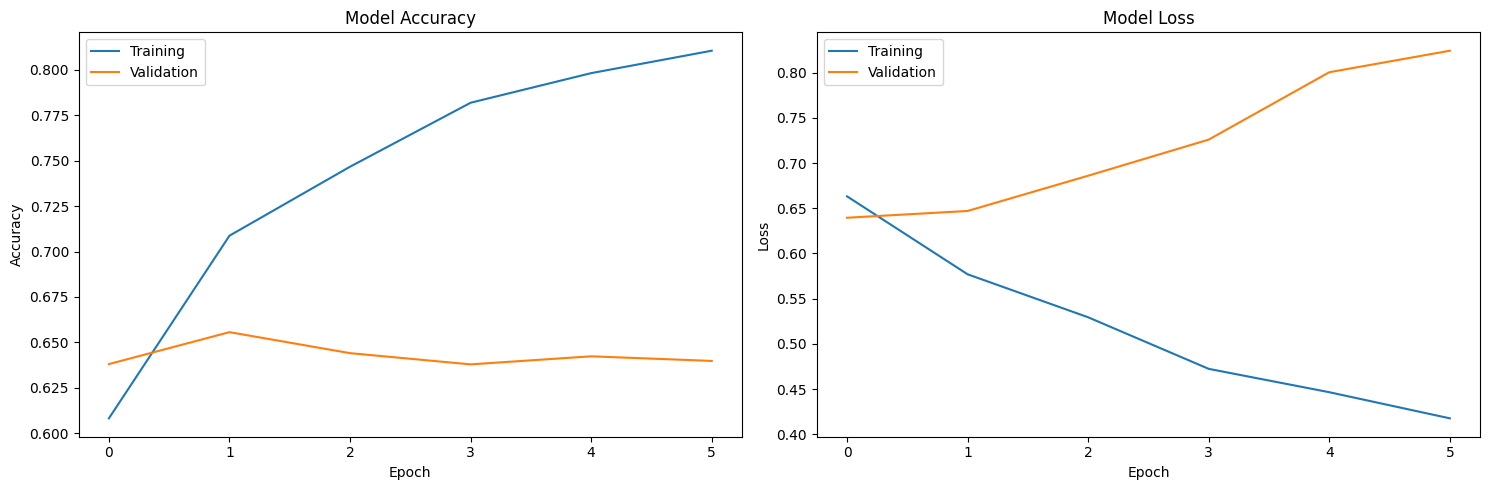


Final Validation Accuracy: 0.6380


In [56]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers

def create_small_dataset_model():
    """Create a model optimized for small datasets"""
    
    model = keras.Sequential([
        # Embedding with strong regularization
        layers.Embedding(
            input_dim=len(vocab)+1,
            output_dim=32,
            input_length=50,
            embeddings_regularizer=keras.regularizers.l2(1e-5),
            mask_zero=True
        ),
        
        # Dropout after embedding
        layers.Dropout(0.3),
        
        # Bidirectional LSTM with strong regularization
        layers.Bidirectional(layers.LSTM(
            units=16,
            kernel_regularizer=keras.regularizers.l2(1e-4),
            recurrent_regularizer=keras.regularizers.l2(1e-4),
            return_sequences=False
        )),
        
        # Batch normalization
        layers.BatchNormalization(),
        
        # Dense with regularization
        layers.Dense(
            8,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(1e-4)
        ),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Simple optimizer with fixed learning rate
    optimizer = keras.optimizers.Adam(
        learning_rate=0.0005,  # Lower learning rate
        clipnorm=1.0  # Gradient clipping
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_small_dataset_model():
    """Train the model with optimizations for small datasets"""
    
    # Create model
    model = create_small_dataset_model()
    
    # Callbacks
    callbacks = [
        # Early stopping
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            min_delta=0.001
        ),
        
        # Reduce learning rate on plateau
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.00001,
            verbose=1
        ),
    ]
    
    # Train with smaller batch size
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Print model summary
model = create_small_dataset_model()
print("\nModel Summary:")
model.summary()

# Train model
print("\nTraining optimized model for small dataset...")
model, history = train_small_dataset_model()

# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")

In [ ]:
# Update sequence and embedding parameters
MAX_LENGTH = 100  # Increased from 25
EMBEDDING_DIM = 200  # Increased embedding dimensions
VOCAB_SIZE = len(vocab) + 1  # Add 1 for padding token

# Create an improved model using GRU (better than SimpleRNN)
def create_improved_model():
    model = keras.Sequential([
        # Embedding layer with spatial dropout
        keras.layers.Embedding(
            VOCAB_SIZE,
            EMBEDDING_DIM,
            input_length=MAX_LENGTH,
            mask_zero=True  # Handle variable length sequences better
        ),
        keras.layers.SpatialDropout1D(0.2),  # Helps prevent overfitting
        
        # Bidirectional GRU layers (better than vanilla RNN)
        keras.layers.Bidirectional(
            keras.layers.GRU(256, return_sequences=True)
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Bidirectional(
            keras.layers.GRU(128)
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        # Dense layers for classification
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile with better learning rate and optimizer settings
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Update data preprocessing with new max_length
X_train = convert_to_sequences(train_data['processed_text'], vocab, max_length=MAX_LENGTH)
X_val = convert_to_sequences(val_data['processed_text'], vocab, max_length=MAX_LENGTH)

# Create and train the improved model
model = create_improved_model()

# Better training callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.0001
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train with larger batch size and more epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()